# 50.039 Theory and Practice of Deep Learning Project 2024

Group 10
- Issac Jose Ignatius (1004999)
- Mahima Sharma (1006106)
- Dian Maisara (1006377)


## Motivation

Chest radiography is an essential diagnostic tool used in medical imaging to visualise structures and organs within the chest cavity. It is crucial for diagnosing various respiratory and heart-related conditions. However, with the increased demand for radiological reports within shorter timeframes to detect and treat illnesses, there have been insufficient radiologists available to perform such tasks at scale. Therefore, automated chest radiograph interpretation could provide substantial benefits supporting large-scale screening and population health initiatives. Deep-learning algorithms can be used to bridge this gap. They have been used for image classification, anomaly detection, organ segmentation, and disease progression prediction.
<br><br>

*In this project, we aim to train a deep neural network to perform multi-label image classification on a wide array of chest radiograph images that exhibit various pathologies.*<br><br>



---




## Import all relevant libraries

In [1]:
# Numpy
import numpy as np
# Pandas
import pandas as pd

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, RandomSampler
import torchvision
import torchvision.transforms as T
from torchvision.transforms import v2
from torchvision.io import read_image, ImageReadMode
from torchmetrics.classification import MulticlassF1Score


# File Operations
import os

# Helper scripts
from tqdm.notebook import tqdm, tnrange
import math
# import sys
# sys.path.insert(0, '../src')
# from saver_loader import *
# %reload_ext autoreload
# %autoreload 2

#print(torchvision.__version__)

In [2]:
def seed_everything(seed):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
seed_everything(42)

In [3]:
# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu") 
print(device)

cuda


## Data Loading

The training and validation datasets are from the **CheXphoto dataset** (Philips et al., 2020). <br><br> CheXphoto comprises a training set of natural photos and synthetic transformations of 10,507 X-ray images from 3,000 unique patients (32,521 data points) sampled at random from the CheXpert training dataset and an accompanying validation set of natural and synthetic transformations applied to all 234 X-ray images from 200 patients with an additional 200 cell phone photos of x-ray films from another 200 unique patients (952 data points).

### Setup environment variables


In [5]:
DATA_PATH = os.path.join(os.path.abspath(''), "../ChexPhoto/chexphoto-v1")
print(DATA_PATH)

c:\Users\User\Desktop\50.039 TPDL\2024_TPDL\notebooks\../ChexPhoto/chexphoto-v1


### Loading dataset (image and labels)

In [6]:
# Bug in Path present in training dataset
def fix_error_paths(row):
    row = row.replace("//", "/")
    return row

def str_to_array(row):
    ndarray = np.fromstring(
                row.replace('\n','')
                    .replace('[','')
                    .replace(']','')
                    .replace('  ',' '), 
                    sep=' ')
    return ndarray

In [7]:
train_df = pd.read_csv("../data/processed/train_one_hot_encoded.csv", index_col=False)
labels = train_df.columns[1:]
print(len(labels), labels)

13 Index(['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices'],
      dtype='object')


In [8]:
valid_df = pd.read_csv("../data/processed/valid_one_hot_encoded.csv", index_col=False)

In [9]:
train_df["Path"] = train_df["Path"].apply(fix_error_paths)

for label in labels:
    train_df[label] = train_df[label].apply(str_to_array)
    valid_df[label] = valid_df[label].apply(str_to_array)

display(train_df)
display(valid_df)

,Path,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXphoto-v1.0/train/synthetic/digital/patient...,"[0.0, 1.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"
1,CheXphoto-v1.0/train/synthetic/digital/patient...,"[0.0, 1.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"
2,CheXphoto-v1.0/train/synthetic/digital/patient...,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"
3,CheXphoto-v1.0/train/synthetic/digital/patient...,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"
4,CheXphoto-v1.0/train/synthetic/digital/patient...,"[0.0, 0.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 1.0, 0.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32516,CheXphoto-v1.0/train/natural/nokia/patient6446...,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[1.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"
32517,CheXphoto-v1.0/train/natural/nokia/patient6446...,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"
32518,CheXphoto-v1.0/train/natural/nokia/patient6446...,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[1.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[1.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"
32519,CheXphoto-v1.0/train/natural/nokia/patient6446...,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"


,Path,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXphoto-v1.0/valid/synthetic/digital/patient...,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]"
1,CheXphoto-v1.0/valid/synthetic/digital/patient...,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]"
2,CheXphoto-v1.0/valid/synthetic/digital/patient...,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]"
3,CheXphoto-v1.0/valid/synthetic/digital/patient...,"[0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]"
4,CheXphoto-v1.0/valid/synthetic/digital/patient...,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
697,CheXphoto-v1.0/valid/natural/oneplus/patient64...,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]"
698,CheXphoto-v1.0/valid/natural/oneplus/patient64...,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]"
699,CheXphoto-v1.0/valid/natural/oneplus/patient64...,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]"
700,CheXphoto-v1.0/valid/natural/oneplus/patient64...,"[0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]"


### Subsetting dataset (Binary Classification for Pleural Effusion)


In [10]:
def keep_observations(df, cols):
    return df[cols].copy()

In [11]:
# Drop all other labels
cols = ["Path", "Pleural Effusion", "Cardiomegaly"]
df_train = keep_observations(train_df, cols)
df_valid = keep_observations(valid_df, cols)

In [12]:
def ohe_to_class(row):
    if np.sum(row) > 0:
        return np.argmax(row)
    else:
        return -100

df_train["Class_pEff"] = df_train["Pleural Effusion"].apply(ohe_to_class)
df_train["Class_cardio"] = df_train["Cardiomegaly"].apply(ohe_to_class)

df_valid["Class_pEff"] = df_valid["Pleural Effusion"].apply(ohe_to_class)
df_valid["Class_cardio"] = df_valid["Cardiomegaly"].apply(ohe_to_class)

In [13]:
display(df_train)
display(df_valid)

,Path,Pleural Effusion,Cardiomegaly,Class_pEff,Class_cardio
0,CheXphoto-v1.0/train/synthetic/digital/patient...,"[0.0, 1.0, 0.0]","[0.0, 0.0, 0.0]",1,-100
1,CheXphoto-v1.0/train/synthetic/digital/patient...,"[0.0, 1.0, 0.0]","[0.0, 0.0, 0.0]",1,-100
2,CheXphoto-v1.0/train/synthetic/digital/patient...,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]",-100,-100
3,CheXphoto-v1.0/train/synthetic/digital/patient...,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]",-100,-100
4,CheXphoto-v1.0/train/synthetic/digital/patient...,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]",2,2
...,...,...,...,...,...
32516,CheXphoto-v1.0/train/natural/nokia/patient6446...,"[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0]",2,-100
32517,CheXphoto-v1.0/train/natural/nokia/patient6446...,"[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0]",2,-100
32518,CheXphoto-v1.0/train/natural/nokia/patient6446...,"[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0]",2,-100
32519,CheXphoto-v1.0/train/natural/nokia/patient6446...,"[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0]",2,-100


,Path,Pleural Effusion,Cardiomegaly,Class_pEff,Class_cardio
0,CheXphoto-v1.0/valid/synthetic/digital/patient...,"[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]",1,2
1,CheXphoto-v1.0/valid/synthetic/digital/patient...,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]",1,1
2,CheXphoto-v1.0/valid/synthetic/digital/patient...,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]",1,1
3,CheXphoto-v1.0/valid/synthetic/digital/patient...,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]",1,1
4,CheXphoto-v1.0/valid/synthetic/digital/patient...,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]",1,1
...,...,...,...,...,...
697,CheXphoto-v1.0/valid/natural/oneplus/patient64...,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]",1,1
698,CheXphoto-v1.0/valid/natural/oneplus/patient64...,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]",1,1
699,CheXphoto-v1.0/valid/natural/oneplus/patient64...,"[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]",1,2
700,CheXphoto-v1.0/valid/natural/oneplus/patient64...,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]",1,1


In [14]:
def sum_array(row):
    return np.sum(row)

df_train["Pleural Effusion_sum"] = df_train["Pleural Effusion"].apply(sum_array)
df_train["Cardiomegaly_sum"] = df_train["Cardiomegaly"].apply(sum_array)

display(df_train)

,Path,Pleural Effusion,Cardiomegaly,Class_pEff,Class_cardio,Pleural Effusion_sum,Cardiomegaly_sum
0,CheXphoto-v1.0/train/synthetic/digital/patient...,"[0.0, 1.0, 0.0]","[0.0, 0.0, 0.0]",1,-100,1.0,0.0
1,CheXphoto-v1.0/train/synthetic/digital/patient...,"[0.0, 1.0, 0.0]","[0.0, 0.0, 0.0]",1,-100,1.0,0.0
2,CheXphoto-v1.0/train/synthetic/digital/patient...,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]",-100,-100,0.0,0.0
3,CheXphoto-v1.0/train/synthetic/digital/patient...,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]",-100,-100,0.0,0.0
4,CheXphoto-v1.0/train/synthetic/digital/patient...,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]",2,2,1.0,1.0
...,...,...,...,...,...,...,...
32516,CheXphoto-v1.0/train/natural/nokia/patient6446...,"[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0]",2,-100,1.0,0.0
32517,CheXphoto-v1.0/train/natural/nokia/patient6446...,"[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0]",2,-100,1.0,0.0
32518,CheXphoto-v1.0/train/natural/nokia/patient6446...,"[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0]",2,-100,1.0,0.0
32519,CheXphoto-v1.0/train/natural/nokia/patient6446...,"[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0]",2,-100,1.0,0.0


In [15]:
df_train = df_train[(df_train["Pleural Effusion_sum"] > 0) | (df_train["Cardiomegaly_sum"] > 0)]

# filter out NaNs in both columns given that we feed class labels to CrossEntropyLoss
cols = ["Path", "Pleural Effusion", "Cardiomegaly", "Class_pEff", "Class_cardio"]
df_train = df_train[cols]
display(df_train)

,Path,Pleural Effusion,Cardiomegaly,Class_pEff,Class_cardio
0,CheXphoto-v1.0/train/synthetic/digital/patient...,"[0.0, 1.0, 0.0]","[0.0, 0.0, 0.0]",1,-100
1,CheXphoto-v1.0/train/synthetic/digital/patient...,"[0.0, 1.0, 0.0]","[0.0, 0.0, 0.0]",1,-100
4,CheXphoto-v1.0/train/synthetic/digital/patient...,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]",2,2
5,CheXphoto-v1.0/train/synthetic/digital/patient...,"[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0]",2,-100
8,CheXphoto-v1.0/train/synthetic/digital/patient...,"[1.0, 0.0, 0.0]","[0.0, 0.0, 0.0]",0,-100
...,...,...,...,...,...
32516,CheXphoto-v1.0/train/natural/nokia/patient6446...,"[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0]",2,-100
32517,CheXphoto-v1.0/train/natural/nokia/patient6446...,"[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0]",2,-100
32518,CheXphoto-v1.0/train/natural/nokia/patient6446...,"[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0]",2,-100
32519,CheXphoto-v1.0/train/natural/nokia/patient6446...,"[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0]",2,-100


### Custom Dataset implementation

In [16]:
# Implementation of Custom Dataset Class for CheXPhoto Dataset
class CheXDataset(Dataset):
    def __init__(self, df: pd.DataFrame, px_size: int = 256):
        self.dataframe = df.copy()
        self.px_size = px_size
        self.transform = T.Compose([
            v2.Resize((self.px_size, self.px_size), interpolation=T.InterpolationMode.BICUBIC)
        ])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        x_path = DATA_PATH + "/" + self.dataframe.iloc[idx, 0].split("CheXphoto-v1.0", 1)[-1]

        resized_x_tensor = self.transform(read_image(x_path, mode = ImageReadMode.RGB)) /255

        y_pEff, y_cardio = torch.tensor(self.dataframe.iloc[idx, 3]).type(torch.LongTensor), torch.tensor(self.dataframe.iloc[idx, 4]).type(torch.LongTensor)
        return resized_x_tensor, y_pEff, y_cardio

### Custom Dataloader

In [17]:
# Load into custom Dataset
train_data = CheXDataset(df_train)
valid_data = CheXDataset(df_valid)

# Prepare random sampler for training subset
train_sampler = RandomSampler(data_source=train_data, num_samples=int(0.2*len(train_data)))
# train_sampler = WeightedRandomSampler([1873/19582, 4976/19582, 12733/19582], int(len(train_data)))

# Load into DataLoader
batch_size = 128
train_loader = DataLoader(train_data, batch_size, sampler=train_sampler)
# train_loader = DataLoader(train_data, batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size)

In [18]:
x, y1, y2 = train_data[0]
print(x, x.shape, x.dtype)
print(y1, y1.shape, y1.dtype)
print(y2, y2.shape, y2.dtype)

tensor([[[0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.0588],
         [0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.0588],
         [0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.0588],
         ...,
         [0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.0588],
         [0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.0588],
         [0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.0588]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.0588],
         [0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.0588],
         [0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.0588],
         ...,
         [0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.0588],
         [0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.0588],
         [0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.0588]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.0588],
         [0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.0588],
         [0.0588, 0.0588, 0.0588,  ..., 0.0588, 0.0588, 0.

## Model Tuning

Our initial model is a simple feedforward neural network with multiple heads (2 heads) capable of classifying for both Cardiomegaly and Pleural Effusion. We will utilise the Cross-entropy loss function to optimise the model during training.

**This is a TODO since it can change**


### First iteration - Simple Convolutional Neural Network

#### Model

In [19]:
class ConvolutionBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int, padding: int, pool_size: int = 2):
        super(ConvolutionBlock, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()
        self.pooling = nn.MaxPool2d(pool_size, pool_size)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.activation(out)
        out = self.pooling(out)
        return out

In [20]:
class FCBlock(nn.Module):
    def __init__(self, in_features: int, out_features: int, dropout_rate: int=0.2):
        super(FCBlock, self).__init__()
        
        self.fc = nn.Linear(in_features, out_features, dtype=torch.float32)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x):
        out = self.fc(x)
        out = self.activation(out)
        out = self.dropout(out)
        return out

In [21]:
class ClassifierBlock(nn.Module):
    def __init__(self, in_features: int, hidden_features: tuple[int], out_features: int, dropout_rate: int = 0.2):
        super(ClassifierBlock, self).__init__()

        self.inputs = FCBlock(in_features, hidden_features[0], dropout_rate)
        self.layers = nn.Sequential(*[FCBlock(hidden_features[i], hidden_features[i+1], dropout_rate) for i in range(len(hidden_features)-1)])
        self.linear = nn.Linear(hidden_features[-1], out_features, dtype=torch.float32)
    
    def forward(self, x):
        out = self.inputs(x)
        out = self.layers(out)
        out = self.linear(out)
        return out

In [22]:
class ConvNet(nn.Module):
    def __init__(self, channels: tuple[int], img_size: tuple[int], hidden_size: tuple[int], output_size: int, dropout_rate: int = 0.2):
        super(ConvNet, self).__init__()
        
        # Hyperparameters for Convolutional Layers
        self.kernel_size = 3
        self.stride = 1
        self.padding = 1
        self.pool_size = 2

        # Input size of Image
        self.input_height, self.input_width = img_size

        # Calculate Input Size of Classifier
        for i in range(len(channels) - 1):
            self.input_height = math.floor((self.input_height + 2 * self.padding - self.kernel_size)/ self.stride + 1) // self.pool_size
            self.input_width =  math.floor((self.input_width  + 2 * self.padding - self.kernel_size)/ self.stride + 1) // self.pool_size
        
        self.classifier_size = channels[-1] * self.input_height * self.input_width
        
        # Model Layers
        self.conv_layers = nn.Sequential(*[ConvolutionBlock(channels[i], channels[i+1], self.kernel_size, self.stride, self.padding, self.pool_size) for i in range(len(channels)-1)])
        self.classifier1 = ClassifierBlock(self.classifier_size, hidden_size, output_size, dropout_rate)
        self.classifier2 = ClassifierBlock(self.classifier_size, hidden_size, output_size, dropout_rate)


    def forward(self,x):
        # Convolutional Layers
        out1 = self.conv_layers(x)

        # keep batch size and flatten the rest
        out2 = out1.view(out1.size(0), -1)

        # Classifier Layers
        out3 = self.classifier1(out2)
        out4 = self.classifier2(out2)
        return out3, out4

In [23]:
def save_json(dict, path):
    if not os.path.exists(path):
        os.makedirs(path)
    
    import json
    fpath = path + "/" + "config.json"
    with open(fpath, "w") as f:
        json.dump(dict, f)

In [24]:
# Create Model
channels = (3, 8, 16, 32, 64, 128, 256)
img_size = (256, 256)
hidden_size = (2048, 256) 
output_size = 3
dropout_rate = 0.2

hyperparams_dict = {}
hyperparams_dict["channels"] = channels
hyperparams_dict["img_size"] = img_size
hyperparams_dict["hidden_size"] = hidden_size
hyperparams_dict["output_size"] = output_size
hyperparams_dict["dropout_rate"] = dropout_rate

save_json(hyperparams_dict, "../models-2/convnet")

model = ConvNet(channels, img_size, hidden_size, output_size, dropout_rate).to(device)
print(model)

ConvNet(
  (conv_layers): Sequential(
    (0): ConvolutionBlock(
      (conv): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
      (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvolutionBlock(
      (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
      (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): ConvolutionBlock(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
      (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


#### Training

In [25]:
def train_loop(model, train_loader, optimizer, loss_pEff, loss_cardio, lambda1, lambda2):
    model.train()

    train_loss = 0
    train_total = 0

    f1_pEff = MulticlassF1Score(num_classes=3, ignore_index=-100).to(device)
    f1_cardio = MulticlassF1Score(num_classes=3, ignore_index=-100).to(device)

    for inputs, outputs_pEff, outputs_cardio in tqdm(train_loader):
        inputs_re, outputs_re_pEff, outputs_re_cardio = inputs.to(device), outputs_pEff.to(device), outputs_cardio.to(device)

        optimizer.zero_grad()
        preds = model(inputs_re)

        # Compute loss
        loss1 = loss_pEff(preds[0], outputs_re_pEff)
        loss2 = loss_cardio(preds[1], outputs_re_cardio)
        loss_value = lambda1*loss1 + lambda2*loss2
        
        # Backpropagation
        loss_value.backward()
        optimizer.step()

        # Compute metric
        train_loss += loss_value.item() * outputs_re_pEff.size(0)
        train_total += outputs_re_pEff.size(0)
        
        f1_pEff.update(preds[0], outputs_re_pEff)
        f1_cardio.update(preds[1], outputs_re_cardio)

    train_loss /= train_total
    train_f1_pEff = f1_pEff.compute() 
    train_f1_cardio = f1_cardio.compute()

    return train_loss, train_f1_pEff, train_f1_cardio

In [26]:
def test_loop(model, valid_loader, loss_pEff, loss_cardio, lambda1, lambda2):
    model.eval()
    
    val_loss = 0
    val_total = 0

    f1_pEff = MulticlassF1Score(num_classes=3, ignore_index=-100).to(device)
    f1_cardio = MulticlassF1Score(num_classes=3, ignore_index=-100).to(device)

    with torch.no_grad():
        for inputs, outputs_pEff, outputs_cardio in tqdm(valid_loader):
            inputs_re, outputs_re_pEff, outputs_re_cardio = inputs.to(device), outputs_pEff.to(device), outputs_cardio.to(device)
            preds = model(inputs_re)

            # Compute loss
            loss1 = loss_pEff(preds[0], outputs_re_pEff)
            loss2 = loss_cardio(preds[1], outputs_re_cardio)
            loss_value = lambda1*loss1 + lambda2*loss2

            # Compute metrics
            val_loss += loss_value.item() * outputs_re_pEff.size(0)
            val_total += outputs_re_pEff.size(0)

            f1_pEff.update(preds[0], outputs_re_pEff)
            f1_cardio.update(preds[1], outputs_re_cardio)

    val_loss /= val_total
    val_f1_pEff = f1_pEff.compute() 
    val_f1_cardio = f1_cardio.compute()

    return val_loss, val_f1_pEff, val_f1_cardio

In [27]:
def save_model(model, optimizer, epoch, path):
    if not os.path.exists(path):
        os.makedirs(path)

    model_path = os.path.join(path, f'{epoch}.pt')

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, model_path)

In [28]:
def train(model, name, train_loader, valid_loader, class_weights_pEff, class_weights_cardio, lambda1, lambda2, epochs=10, lr=1e-4):
    # Adam
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # loss function
    loss_pEff = nn.CrossEntropyLoss(weight=class_weights_pEff, ignore_index=-100).to(device)
    loss_cardio = nn.CrossEntropyLoss(weight=class_weights_cardio, ignore_index=-100).to(device)

    # Keep track of losses and F1 scores
    train_pEff_loss_values = []
    train_pEFF_f1_values = []
    val_pEff_loss_values = []
    val_pEFF_f1_values = []

    train_cardio_loss_values = []
    train_cardio_f1_values = []
    val_cardio_loss_values = []
    val_cardio_f1_values = []

    for epoch in tnrange(epochs):
        # Train loop
        train_loss, train_f1_pEff, train_f1_cardio = train_loop(model, train_loader, optimizer, loss_pEff, loss_cardio, lambda1, lambda2)

        train_pEff_loss_values.append(train_loss)
        train_pEFF_f1_values.append(train_f1_pEff)
        train_cardio_loss_values.append(train_loss)
        train_cardio_f1_values.append(train_f1_cardio)

        # Test loop
        val_loss, val_f1_pEff, val_f1_cardio = test_loop(model, valid_loader, loss_pEff, loss_cardio, lambda1, lambda2)

        val_pEff_loss_values.append(val_loss)
        val_pEFF_f1_values.append(val_f1_pEff)
        val_cardio_loss_values.append(val_loss)
        val_cardio_f1_values.append(val_f1_cardio)

        print(f"--- Epoch {epoch+1}/{epochs}: ---")
        print(f"Train loss: {train_loss:.4f}, Train f1(Pleural): {train_f1_pEff:.4f}, Train f1(Cardio): {train_f1_cardio:.4f}")
        print(f"Validation loss: {val_loss:.4f}, Validation f1(Pleural): {val_f1_pEff:.4f}, Validation f1(Cardio): {val_f1_cardio:.4f}")

        save_model(model, optimizer, epoch, path=f'../models-2/{name}')

    return train_pEff_loss_values, train_pEFF_f1_values, val_pEff_loss_values, val_pEFF_f1_values, train_cardio_loss_values, train_cardio_f1_values, val_cardio_loss_values, val_cardio_f1_values

In [29]:
epochs = 50

# loss hyperparameters - penalise minority class loss more
#lambda1 = (19582+6812)/19582
#lambda2 = (19582+6812)/6812

lambda1 = (19582+6812)/19582
lambda2 = 19582/6812

# lambda1 = 1
# lambda2 = 1

# lambda1 = 6812/19582
# lambda2 = 19582/6812

# class weights
class_weights_pEff = torch.tensor([1873/19582, 4976/19582, 12733/19582]).to(device)
class_weights_cardio = torch.tensor([1149/6812, 1623/6812, 4040/6812]).to(device)
model_name = "convnet"

convnet_stats = train(model, model_name, train_loader, valid_loader, class_weights_pEff, class_weights_cardio, lambda1, lambda2, epochs, lr=1e-4)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 1/50: ---
Train loss: 2.5040, Train f1(Pleural): 0.2679, Train f1(Cardio): 0.2563
Validation loss: 4.7440, Validation f1(Pleural): 0.2226, Validation f1(Cardio): 0.2252


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 2/50: ---
Train loss: 2.2879, Train f1(Pleural): 0.2857, Train f1(Cardio): 0.2628
Validation loss: 4.2777, Validation f1(Pleural): 0.2548, Validation f1(Cardio): 0.2319


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 3/50: ---
Train loss: 2.1560, Train f1(Pleural): 0.3438, Train f1(Cardio): 0.3175
Validation loss: 4.1997, Validation f1(Pleural): 0.4516, Validation f1(Cardio): 0.2341


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 4/50: ---
Train loss: 2.1124, Train f1(Pleural): 0.3925, Train f1(Cardio): 0.3284
Validation loss: 2.9859, Validation f1(Pleural): 0.5517, Validation f1(Cardio): 0.5958


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 5/50: ---
Train loss: 2.0865, Train f1(Pleural): 0.4208, Train f1(Cardio): 0.3687
Validation loss: 3.6594, Validation f1(Pleural): 0.4758, Validation f1(Cardio): 0.3914


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 6/50: ---
Train loss: 2.0318, Train f1(Pleural): 0.4124, Train f1(Cardio): 0.3586
Validation loss: 4.1827, Validation f1(Pleural): 0.4811, Validation f1(Cardio): 0.3449


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 7/50: ---
Train loss: 1.9953, Train f1(Pleural): 0.4126, Train f1(Cardio): 0.3927
Validation loss: 3.2606, Validation f1(Pleural): 0.5399, Validation f1(Cardio): 0.5790


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 8/50: ---
Train loss: 2.0965, Train f1(Pleural): 0.4250, Train f1(Cardio): 0.4449
Validation loss: 4.1286, Validation f1(Pleural): 0.3477, Validation f1(Cardio): 0.4179


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 9/50: ---
Train loss: 1.8935, Train f1(Pleural): 0.4249, Train f1(Cardio): 0.4239
Validation loss: 4.0388, Validation f1(Pleural): 0.4481, Validation f1(Cardio): 0.4131


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 10/50: ---
Train loss: 1.8715, Train f1(Pleural): 0.4235, Train f1(Cardio): 0.4475
Validation loss: 5.1402, Validation f1(Pleural): 0.2949, Validation f1(Cardio): 0.3198


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 11/50: ---
Train loss: 1.8288, Train f1(Pleural): 0.4506, Train f1(Cardio): 0.4637
Validation loss: 3.1708, Validation f1(Pleural): 0.4804, Validation f1(Cardio): 0.6174


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 12/50: ---
Train loss: 1.8714, Train f1(Pleural): 0.4519, Train f1(Cardio): 0.4495
Validation loss: 3.5605, Validation f1(Pleural): 0.5648, Validation f1(Cardio): 0.4869


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 13/50: ---
Train loss: 1.7752, Train f1(Pleural): 0.4638, Train f1(Cardio): 0.4805
Validation loss: 3.9127, Validation f1(Pleural): 0.5107, Validation f1(Cardio): 0.4929


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 14/50: ---
Train loss: 1.7133, Train f1(Pleural): 0.4511, Train f1(Cardio): 0.4808
Validation loss: 3.3113, Validation f1(Pleural): 0.4335, Validation f1(Cardio): 0.6064


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 15/50: ---
Train loss: 1.7959, Train f1(Pleural): 0.4449, Train f1(Cardio): 0.4601
Validation loss: 3.4672, Validation f1(Pleural): 0.5634, Validation f1(Cardio): 0.5226


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 16/50: ---
Train loss: 1.7807, Train f1(Pleural): 0.4518, Train f1(Cardio): 0.4791
Validation loss: 4.9432, Validation f1(Pleural): 0.5770, Validation f1(Cardio): 0.3159


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 17/50: ---
Train loss: 1.7014, Train f1(Pleural): 0.4554, Train f1(Cardio): 0.4877
Validation loss: 5.4008, Validation f1(Pleural): 0.4456, Validation f1(Cardio): 0.3321


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 18/50: ---
Train loss: 1.6831, Train f1(Pleural): 0.4743, Train f1(Cardio): 0.4938
Validation loss: 5.7853, Validation f1(Pleural): 0.5484, Validation f1(Cardio): 0.3397


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 19/50: ---
Train loss: 1.6645, Train f1(Pleural): 0.4619, Train f1(Cardio): 0.4975
Validation loss: 4.6914, Validation f1(Pleural): 0.4407, Validation f1(Cardio): 0.4396


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 20/50: ---
Train loss: 1.5593, Train f1(Pleural): 0.4746, Train f1(Cardio): 0.5247
Validation loss: 4.2970, Validation f1(Pleural): 0.5554, Validation f1(Cardio): 0.4950


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 21/50: ---
Train loss: 1.5186, Train f1(Pleural): 0.4733, Train f1(Cardio): 0.5293
Validation loss: 4.4412, Validation f1(Pleural): 0.5399, Validation f1(Cardio): 0.4995


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 22/50: ---
Train loss: 1.5076, Train f1(Pleural): 0.4830, Train f1(Cardio): 0.5381
Validation loss: 6.0265, Validation f1(Pleural): 0.5660, Validation f1(Cardio): 0.4070


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 23/50: ---
Train loss: 1.4317, Train f1(Pleural): 0.4929, Train f1(Cardio): 0.5377
Validation loss: 4.2764, Validation f1(Pleural): 0.6545, Validation f1(Cardio): 0.5019


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 24/50: ---
Train loss: 1.3763, Train f1(Pleural): 0.4890, Train f1(Cardio): 0.5544
Validation loss: 5.5199, Validation f1(Pleural): 0.5412, Validation f1(Cardio): 0.4376


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 25/50: ---
Train loss: 1.5211, Train f1(Pleural): 0.4894, Train f1(Cardio): 0.5245
Validation loss: 4.1075, Validation f1(Pleural): 0.5679, Validation f1(Cardio): 0.4964


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 26/50: ---
Train loss: 1.3525, Train f1(Pleural): 0.4976, Train f1(Cardio): 0.5449
Validation loss: 5.9747, Validation f1(Pleural): 0.3983, Validation f1(Cardio): 0.4436


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 27/50: ---
Train loss: 1.2832, Train f1(Pleural): 0.4891, Train f1(Cardio): 0.5670
Validation loss: 5.1333, Validation f1(Pleural): 0.5683, Validation f1(Cardio): 0.4672


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 28/50: ---
Train loss: 1.2484, Train f1(Pleural): 0.5011, Train f1(Cardio): 0.5776
Validation loss: 6.0403, Validation f1(Pleural): 0.5298, Validation f1(Cardio): 0.4391


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 29/50: ---
Train loss: 1.2352, Train f1(Pleural): 0.5043, Train f1(Cardio): 0.5899
Validation loss: 4.3364, Validation f1(Pleural): 0.4927, Validation f1(Cardio): 0.3880


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 30/50: ---
Train loss: 1.1954, Train f1(Pleural): 0.4973, Train f1(Cardio): 0.6117
Validation loss: 6.7823, Validation f1(Pleural): 0.4969, Validation f1(Cardio): 0.2880


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 31/50: ---
Train loss: 1.0945, Train f1(Pleural): 0.5131, Train f1(Cardio): 0.6526
Validation loss: 6.0096, Validation f1(Pleural): 0.5561, Validation f1(Cardio): 0.4746


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 32/50: ---
Train loss: 1.2166, Train f1(Pleural): 0.5131, Train f1(Cardio): 0.6081
Validation loss: 4.3027, Validation f1(Pleural): 0.6224, Validation f1(Cardio): 0.3923


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 33/50: ---
Train loss: 1.0815, Train f1(Pleural): 0.5172, Train f1(Cardio): 0.6546
Validation loss: 6.3516, Validation f1(Pleural): 0.4788, Validation f1(Cardio): 0.3129


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 34/50: ---
Train loss: 1.2552, Train f1(Pleural): 0.5207, Train f1(Cardio): 0.6183
Validation loss: 4.7902, Validation f1(Pleural): 0.5895, Validation f1(Cardio): 0.3493


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 35/50: ---
Train loss: 1.1299, Train f1(Pleural): 0.5010, Train f1(Cardio): 0.6814
Validation loss: 5.0710, Validation f1(Pleural): 0.4742, Validation f1(Cardio): 0.5626


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 36/50: ---
Train loss: 0.9674, Train f1(Pleural): 0.5135, Train f1(Cardio): 0.6960
Validation loss: 5.1450, Validation f1(Pleural): 0.6255, Validation f1(Cardio): 0.3808


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 37/50: ---
Train loss: 0.9820, Train f1(Pleural): 0.5177, Train f1(Cardio): 0.7141
Validation loss: 6.0858, Validation f1(Pleural): 0.5744, Validation f1(Cardio): 0.3452


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 38/50: ---
Train loss: 0.8870, Train f1(Pleural): 0.5365, Train f1(Cardio): 0.7579
Validation loss: 7.1258, Validation f1(Pleural): 0.5013, Validation f1(Cardio): 0.3053


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 39/50: ---
Train loss: 1.0513, Train f1(Pleural): 0.5200, Train f1(Cardio): 0.6956
Validation loss: 5.8383, Validation f1(Pleural): 0.4118, Validation f1(Cardio): 0.3783


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 40/50: ---
Train loss: 1.0101, Train f1(Pleural): 0.5247, Train f1(Cardio): 0.7240
Validation loss: 7.0705, Validation f1(Pleural): 0.5636, Validation f1(Cardio): 0.3129


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 41/50: ---
Train loss: 0.7767, Train f1(Pleural): 0.5253, Train f1(Cardio): 0.7852
Validation loss: 6.9239, Validation f1(Pleural): 0.6321, Validation f1(Cardio): 0.3251


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 42/50: ---
Train loss: 0.7968, Train f1(Pleural): 0.5286, Train f1(Cardio): 0.8455
Validation loss: 7.9191, Validation f1(Pleural): 0.5536, Validation f1(Cardio): 0.3093


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 43/50: ---
Train loss: 0.7140, Train f1(Pleural): 0.5398, Train f1(Cardio): 0.8143
Validation loss: 6.7646, Validation f1(Pleural): 0.5791, Validation f1(Cardio): 0.3300


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 44/50: ---
Train loss: 0.7742, Train f1(Pleural): 0.5385, Train f1(Cardio): 0.8311
Validation loss: 8.3345, Validation f1(Pleural): 0.4963, Validation f1(Cardio): 0.2959


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 45/50: ---
Train loss: 0.6965, Train f1(Pleural): 0.5420, Train f1(Cardio): 0.8233
Validation loss: 6.0510, Validation f1(Pleural): 0.6104, Validation f1(Cardio): 0.3671


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 46/50: ---
Train loss: 0.6967, Train f1(Pleural): 0.5381, Train f1(Cardio): 0.8697
Validation loss: 8.6822, Validation f1(Pleural): 0.5710, Validation f1(Cardio): 0.3117


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 47/50: ---
Train loss: 0.6060, Train f1(Pleural): 0.5504, Train f1(Cardio): 0.8844
Validation loss: 8.3858, Validation f1(Pleural): 0.4664, Validation f1(Cardio): 0.3008


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 48/50: ---
Train loss: 0.5803, Train f1(Pleural): 0.5459, Train f1(Cardio): 0.9062
Validation loss: 8.1763, Validation f1(Pleural): 0.5887, Validation f1(Cardio): 0.3181


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 49/50: ---
Train loss: 0.6314, Train f1(Pleural): 0.5586, Train f1(Cardio): 0.8572
Validation loss: 7.4154, Validation f1(Pleural): 0.5770, Validation f1(Cardio): 0.3231


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 50/50: ---
Train loss: 0.5291, Train f1(Pleural): 0.5581, Train f1(Cardio): 0.9294
Validation loss: 7.4912, Validation f1(Pleural): 0.4523, Validation f1(Cardio): 0.3892


### Second iteration - Convolutional neural network (CNN) with Skip Connection

#### Model

In [30]:
class SkipBlock(nn.Module):
    def __init__(self, in_channels: int, hidden_channels: int, out_channels: int, kernel_size: int, stride: int, padding: int, pool_size: int = 2):
        super(SkipBlock, self).__init__()

        # Conv Layers + Skip Connections
        self.conv1 = ConvolutionBlock(in_channels, hidden_channels, kernel_size, stride, padding, pool_size)
        self.conv2 = ConvolutionBlock(hidden_channels, out_channels, kernel_size, stride, padding, pool_size)

        # TODO: Try out 2 different skip connection implementation
        # self.skip_connection = nn.Sequential(nn.Conv2d(channels[0], channels[2], kernel_size=1, stride=2*self.stride, padding=self.padding),
        #                                       nn.AvgPool2d(self.pool_size, self.pool_size))
        
        self.skip_connection = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=padding),
                                              nn.AvgPool2d(2*pool_size, 2*pool_size)
                                              )
        
    def forward(self, x):
        x1 = self.conv1(x)
        out = self.conv2(x1)

        skip = self.skip_connection(x)
        out += skip
        return out

In [31]:
class SkipNet(nn.Module):
    def __init__(self, channels: tuple[int], img_size: tuple[int], hidden_size: tuple[int], output_size: int, dropout_rate: int = 0.2):
        super(SkipNet, self).__init__()
        
        if len(channels) % 2 != 1:
            raise Exception("len(channels) must be an odd number!")
        elif channels[0] != 3:
            raise Exception("first element in channels must match the input channel size!")

        # Hyperparameters for Convolutional Layers
        self.kernel_size = 3
        self.stride = 1
        self.padding = 1
        self.pool_size = 2

        # Input size of Image
        self.input_height, self.input_width = img_size

        # Calculate Input Size of Classifier
        for i in range(len(channels) - 1):
            self.input_height = math.floor((self.input_height + 2 * self.padding - self.kernel_size)/ self.stride + 1) // self.pool_size
            self.input_width =  math.floor((self.input_width  + 2 * self.padding - self.kernel_size)/ self.stride + 1) // self.pool_size
            
        self.classifier_size = channels[-1] * self.input_height * self.input_width

        # Conv Layers + Skip Connections
        self.skip_layers = nn.Sequential(*[SkipBlock(channels[i], channels[i+1], channels[i+2], self.kernel_size, self.stride, self.padding, self.pool_size) for i in range(0, len(channels)-2, 2)])

        # Dropout Layer
        self.dropout = nn.Dropout(dropout_rate)

        # Classifier Layers
        self.classifier1 = ClassifierBlock(self.classifier_size, hidden_size, output_size, dropout_rate)
        self.classifier2 = ClassifierBlock(self.classifier_size, hidden_size, output_size, dropout_rate)
        

    def forward(self,x):
        # SkipBlock layers
        x1 = self.skip_layers(x)

        # Flatten output of convolutions
        x2 = x1.view(x1.size(0), -1)
        # print(x.shape)
        x3 = self.dropout(x2)

        # Classifier layer
        x4 = self.classifier1(x3)
        x5 = self.classifier2(x3)
        
        return x4, x5

In [32]:
# Create Model
# model = torchvision.models.resnet18(weights=False).to(device) # to check if trainer works

channels = (3, 8, 16, 32, 64, 128, 256)
img_size = (256, 256)
hidden_size = (2048, 256) 
output_size = 3
dropout_rate = 0.2

hyperparams_dict = {}
hyperparams_dict["channels"] = channels
hyperparams_dict["img_size"] = img_size
hyperparams_dict["hidden_size"] = hidden_size
hyperparams_dict["output_size"] = output_size
hyperparams_dict["dropout_rate"] = dropout_rate

save_json(hyperparams_dict, "../models-2/skipnet")

model = SkipNet(channels, img_size, hidden_size, output_size, dropout_rate).to(device)
print(model)

SkipNet(
  (skip_layers): Sequential(
    (0): SkipBlock(
      (conv1): ConvolutionBlock(
        (conv): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
        (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (conv2): ConvolutionBlock(
        (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
        (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (skip_connection): Sequential(
        (0): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
        (1): AvgPool2d(kernel_size=4, stride=4, padding=0)
      )
    )
    (1): SkipBlock(
      (conv1): ConvolutionBlock(
        (conv): Conv2d(16

In [33]:
epochs = 50

# loss hyperparameters - penalise minority class loss more
#lambda1 = (19582+6812)/19582
#lambda2 = (19582+6812)/6812

# lambda1 = 1
# lambda2 = 1

lambda1 = (19582+6812)/19582
lambda2 = 19582/6812

# lambda1 = 6812/19582
# lambda2 = 19582/6812

# class weights
class_weights_pEff = torch.tensor([1873/19582, 4976/19582, 12733/19582]).to(device)
class_weights_cardio = torch.tensor([1149/6812, 1623/6812, 4040/6812]).to(device)
model_name = "skipnet"

skipnet_stats = train(model, model_name, train_loader, valid_loader, class_weights_pEff, class_weights_cardio, lambda1, lambda2, epochs, lr=1e-4)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 1/50: ---
Train loss: 2.4823, Train f1(Pleural): 0.2647, Train f1(Cardio): 0.2601
Validation loss: 4.2577, Validation f1(Pleural): 0.2226, Validation f1(Cardio): 0.2252


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 2/50: ---
Train loss: 2.2870, Train f1(Pleural): 0.2922, Train f1(Cardio): 0.2588
Validation loss: 4.0674, Validation f1(Pleural): 0.3548, Validation f1(Cardio): 0.2297


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 3/50: ---
Train loss: 2.1516, Train f1(Pleural): 0.3650, Train f1(Cardio): 0.3239
Validation loss: 3.5620, Validation f1(Pleural): 0.5462, Validation f1(Cardio): 0.4063


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 4/50: ---
Train loss: 2.0567, Train f1(Pleural): 0.4034, Train f1(Cardio): 0.3621
Validation loss: 3.3710, Validation f1(Pleural): 0.5440, Validation f1(Cardio): 0.4696


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 5/50: ---
Train loss: 2.0370, Train f1(Pleural): 0.4181, Train f1(Cardio): 0.3813
Validation loss: 3.6855, Validation f1(Pleural): 0.4140, Validation f1(Cardio): 0.4172


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 6/50: ---
Train loss: 2.0759, Train f1(Pleural): 0.4136, Train f1(Cardio): 0.3628
Validation loss: 4.2404, Validation f1(Pleural): 0.3221, Validation f1(Cardio): 0.3528


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 7/50: ---
Train loss: 1.8964, Train f1(Pleural): 0.4292, Train f1(Cardio): 0.4350
Validation loss: 3.7378, Validation f1(Pleural): 0.5678, Validation f1(Cardio): 0.4622


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 8/50: ---
Train loss: 1.9162, Train f1(Pleural): 0.4392, Train f1(Cardio): 0.4324
Validation loss: 3.5001, Validation f1(Pleural): 0.5180, Validation f1(Cardio): 0.4714


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 9/50: ---
Train loss: 1.8548, Train f1(Pleural): 0.4252, Train f1(Cardio): 0.4403
Validation loss: 3.4846, Validation f1(Pleural): 0.5061, Validation f1(Cardio): 0.4604


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 10/50: ---
Train loss: 1.9199, Train f1(Pleural): 0.4527, Train f1(Cardio): 0.4435
Validation loss: 3.6017, Validation f1(Pleural): 0.3784, Validation f1(Cardio): 0.5170


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 11/50: ---
Train loss: 1.8737, Train f1(Pleural): 0.4430, Train f1(Cardio): 0.4531
Validation loss: 4.0727, Validation f1(Pleural): 0.3108, Validation f1(Cardio): 0.4285


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 12/50: ---
Train loss: 1.7425, Train f1(Pleural): 0.4610, Train f1(Cardio): 0.4641
Validation loss: 3.7889, Validation f1(Pleural): 0.4485, Validation f1(Cardio): 0.5063


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 13/50: ---
Train loss: 1.7829, Train f1(Pleural): 0.4582, Train f1(Cardio): 0.4739
Validation loss: 3.1060, Validation f1(Pleural): 0.6223, Validation f1(Cardio): 0.5384


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 14/50: ---
Train loss: 1.7819, Train f1(Pleural): 0.4515, Train f1(Cardio): 0.4861
Validation loss: 4.0013, Validation f1(Pleural): 0.4269, Validation f1(Cardio): 0.4784


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 15/50: ---
Train loss: 1.7572, Train f1(Pleural): 0.4735, Train f1(Cardio): 0.4858
Validation loss: 3.3922, Validation f1(Pleural): 0.5677, Validation f1(Cardio): 0.5589


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 16/50: ---
Train loss: 1.7227, Train f1(Pleural): 0.4528, Train f1(Cardio): 0.4982
Validation loss: 4.2837, Validation f1(Pleural): 0.4261, Validation f1(Cardio): 0.4823


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 17/50: ---
Train loss: 1.6405, Train f1(Pleural): 0.4658, Train f1(Cardio): 0.5047
Validation loss: 4.1160, Validation f1(Pleural): 0.5185, Validation f1(Cardio): 0.5085


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 18/50: ---
Train loss: 1.6839, Train f1(Pleural): 0.4711, Train f1(Cardio): 0.5082
Validation loss: 6.4661, Validation f1(Pleural): 0.4194, Validation f1(Cardio): 0.3059


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 19/50: ---
Train loss: 1.4931, Train f1(Pleural): 0.4848, Train f1(Cardio): 0.5127
Validation loss: 4.4154, Validation f1(Pleural): 0.5537, Validation f1(Cardio): 0.4878


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 20/50: ---
Train loss: 1.6289, Train f1(Pleural): 0.4960, Train f1(Cardio): 0.5240
Validation loss: 4.3189, Validation f1(Pleural): 0.4074, Validation f1(Cardio): 0.5342


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 21/50: ---
Train loss: 1.4241, Train f1(Pleural): 0.4920, Train f1(Cardio): 0.5357
Validation loss: 6.2161, Validation f1(Pleural): 0.4979, Validation f1(Cardio): 0.3778


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 22/50: ---
Train loss: 1.5078, Train f1(Pleural): 0.4910, Train f1(Cardio): 0.5231
Validation loss: 4.7054, Validation f1(Pleural): 0.6064, Validation f1(Cardio): 0.4790


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 23/50: ---
Train loss: 1.4206, Train f1(Pleural): 0.4939, Train f1(Cardio): 0.5502
Validation loss: 6.1990, Validation f1(Pleural): 0.3621, Validation f1(Cardio): 0.3279


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 24/50: ---
Train loss: 1.3855, Train f1(Pleural): 0.4691, Train f1(Cardio): 0.5557
Validation loss: 4.6870, Validation f1(Pleural): 0.5754, Validation f1(Cardio): 0.5214


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 25/50: ---
Train loss: 1.3148, Train f1(Pleural): 0.4951, Train f1(Cardio): 0.5815
Validation loss: 4.7625, Validation f1(Pleural): 0.5378, Validation f1(Cardio): 0.3449


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 26/50: ---
Train loss: 1.2456, Train f1(Pleural): 0.4841, Train f1(Cardio): 0.5869
Validation loss: 4.8353, Validation f1(Pleural): 0.5937, Validation f1(Cardio): 0.3630


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 27/50: ---
Train loss: 1.1397, Train f1(Pleural): 0.5062, Train f1(Cardio): 0.6224
Validation loss: 6.2437, Validation f1(Pleural): 0.4756, Validation f1(Cardio): 0.3297


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 28/50: ---
Train loss: 1.3855, Train f1(Pleural): 0.4954, Train f1(Cardio): 0.5634
Validation loss: 4.5288, Validation f1(Pleural): 0.5054, Validation f1(Cardio): 0.3514


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 29/50: ---
Train loss: 1.2518, Train f1(Pleural): 0.5135, Train f1(Cardio): 0.5881
Validation loss: 5.2709, Validation f1(Pleural): 0.5770, Validation f1(Cardio): 0.3304


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 30/50: ---
Train loss: 1.1464, Train f1(Pleural): 0.5024, Train f1(Cardio): 0.6550
Validation loss: 5.2565, Validation f1(Pleural): 0.6705, Validation f1(Cardio): 0.3477


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 31/50: ---
Train loss: 1.2599, Train f1(Pleural): 0.5030, Train f1(Cardio): 0.6153
Validation loss: 6.7057, Validation f1(Pleural): 0.3425, Validation f1(Cardio): 0.2979


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 32/50: ---
Train loss: 1.0581, Train f1(Pleural): 0.5114, Train f1(Cardio): 0.6904
Validation loss: 6.9783, Validation f1(Pleural): 0.4996, Validation f1(Cardio): 0.3159


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 33/50: ---
Train loss: 1.0946, Train f1(Pleural): 0.5186, Train f1(Cardio): 0.6764
Validation loss: 6.2911, Validation f1(Pleural): 0.5554, Validation f1(Cardio): 0.2975


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 34/50: ---
Train loss: 1.0062, Train f1(Pleural): 0.5148, Train f1(Cardio): 0.7247
Validation loss: 5.8147, Validation f1(Pleural): 0.5470, Validation f1(Cardio): 0.3727


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 35/50: ---
Train loss: 1.0366, Train f1(Pleural): 0.5106, Train f1(Cardio): 0.7182
Validation loss: 6.4026, Validation f1(Pleural): 0.5408, Validation f1(Cardio): 0.3369


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 36/50: ---
Train loss: 0.9310, Train f1(Pleural): 0.5212, Train f1(Cardio): 0.7435
Validation loss: 7.6941, Validation f1(Pleural): 0.5344, Validation f1(Cardio): 0.3085


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 37/50: ---
Train loss: 0.9712, Train f1(Pleural): 0.5230, Train f1(Cardio): 0.7578
Validation loss: 8.1420, Validation f1(Pleural): 0.3767, Validation f1(Cardio): 0.3127


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 38/50: ---
Train loss: 0.8464, Train f1(Pleural): 0.5252, Train f1(Cardio): 0.7875
Validation loss: 6.4572, Validation f1(Pleural): 0.5722, Validation f1(Cardio): 0.3505


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 39/50: ---
Train loss: 0.8970, Train f1(Pleural): 0.5220, Train f1(Cardio): 0.8069
Validation loss: 8.3180, Validation f1(Pleural): 0.4482, Validation f1(Cardio): 0.2930


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 40/50: ---
Train loss: 0.8777, Train f1(Pleural): 0.5241, Train f1(Cardio): 0.8051
Validation loss: 7.7992, Validation f1(Pleural): 0.6434, Validation f1(Cardio): 0.3226


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 41/50: ---
Train loss: 0.8309, Train f1(Pleural): 0.5341, Train f1(Cardio): 0.8115
Validation loss: 7.7895, Validation f1(Pleural): 0.5651, Validation f1(Cardio): 0.3026


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 42/50: ---
Train loss: 0.8306, Train f1(Pleural): 0.5378, Train f1(Cardio): 0.8023
Validation loss: 7.1314, Validation f1(Pleural): 0.5771, Validation f1(Cardio): 0.3099


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 43/50: ---
Train loss: 0.7085, Train f1(Pleural): 0.5295, Train f1(Cardio): 0.8543
Validation loss: 7.1819, Validation f1(Pleural): 0.6222, Validation f1(Cardio): 0.3454


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 44/50: ---
Train loss: 0.6986, Train f1(Pleural): 0.5412, Train f1(Cardio): 0.8388
Validation loss: 8.6118, Validation f1(Pleural): 0.5353, Validation f1(Cardio): 0.3244


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 45/50: ---
Train loss: 0.7369, Train f1(Pleural): 0.5435, Train f1(Cardio): 0.8453
Validation loss: 7.9069, Validation f1(Pleural): 0.6199, Validation f1(Cardio): 0.3347


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 46/50: ---
Train loss: 0.7463, Train f1(Pleural): 0.5399, Train f1(Cardio): 0.8596
Validation loss: 6.4492, Validation f1(Pleural): 0.6323, Validation f1(Cardio): 0.3677


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 47/50: ---
Train loss: 0.6433, Train f1(Pleural): 0.5456, Train f1(Cardio): 0.8784
Validation loss: 8.0577, Validation f1(Pleural): 0.6129, Validation f1(Cardio): 0.3242


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 48/50: ---
Train loss: 0.6221, Train f1(Pleural): 0.5474, Train f1(Cardio): 0.8705
Validation loss: 9.0099, Validation f1(Pleural): 0.5403, Validation f1(Cardio): 0.3210


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 49/50: ---
Train loss: 0.5478, Train f1(Pleural): 0.5547, Train f1(Cardio): 0.9015
Validation loss: 8.0844, Validation f1(Pleural): 0.6139, Validation f1(Cardio): 0.3467


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 50/50: ---
Train loss: 0.5237, Train f1(Pleural): 0.5637, Train f1(Cardio): 0.9087
Validation loss: 7.9285, Validation f1(Pleural): 0.6232, Validation f1(Cardio): 0.3464


### Third iteration - ResNet Model

In [34]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
    
    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample:
            identity = self.downsample(x)
        
        out += identity
        out = self.relu(out)
        return out

In [35]:
class ResNet(nn.Module):
    def __init__(self, res_layers: tuple[int], classifier_layers1: tuple[int], classifier_layers2: tuple[int], num_classes: int=3):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        
        self.layer1 = self.make_layer(64, res_layers[0])
        self.layer2 = self.make_layer(128, res_layers[1], stride=2)
        self.layer3 = self.make_layer(256, res_layers[2], stride=2)
        self.layer4 = self.make_layer(512, res_layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, classifier_layers1[0])

        self.classifier1 = ClassifierBlock(classifier_layers1[0], classifier_layers1[1:], num_classes, 0.2)
        self.classifier2 = ClassifierBlock(classifier_layers2[0], classifier_layers2[1:], num_classes, 0.2)
    
    def make_layer(self, out_channels, blocks, stride=1):
        downsample = None

        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels))
            
        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride, downsample))

        self.in_channels = out_channels

        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        x1 = self.classifier1(x)
        x2 = self.classifier2(x)
        return x1, x2

In [36]:
res_layers = (2, 2, 2, 2)
classifier_layers1 = (2048, 1024, 256, 64)
classifier_layers2 = (2048, 256, 64)
num_classes = 3

hyperparams_dict = {}

hyperparams_dict["res_layers"] = res_layers
hyperparams_dict["classifier_layers1"] = classifier_layers1
hyperparams_dict["classifier_layers2"] = classifier_layers2
hyperparams_dict["num_classes"] = num_classes

save_json(hyperparams_dict, "../models-2/resnet")

model = ResNet(res_layers, classifier_layers1, classifier_layers2, num_classes).to(device)

In [37]:
epochs = 50

# loss hyperparameters - penalise minority class loss more
#lambda1 = (19582+6812)/19582
#lambda2 = (19582+6812)/6812

# lambda1 = 1
# lambda2 = 1

lambda1 = (19582+6812)/19582
lambda2 = 19582/6812

# lambda1 = 6812/19582
# lambda2 = 19582/6812

# class weights
class_weights_pEff = torch.tensor([1873/19582, 4976/19582, 12733/19582]).to(device)
class_weights_cardio = torch.tensor([1149/6812, 1623/6812, 4040/6812]).to(device)
model_name = "resnet"

resnet_stats = train(model, model_name, train_loader, valid_loader, class_weights_pEff, class_weights_cardio, lambda1, lambda2, epochs, lr=1e-4)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 1/50: ---
Train loss: 2.8373, Train f1(Pleural): 0.2991, Train f1(Cardio): 0.2594
Validation loss: 4.0543, Validation f1(Pleural): 0.2226, Validation f1(Cardio): 0.2252


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 2/50: ---
Train loss: 2.3064, Train f1(Pleural): 0.2645, Train f1(Cardio): 0.2469
Validation loss: 3.4324, Validation f1(Pleural): 0.2226, Validation f1(Cardio): 0.2603


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 3/50: ---
Train loss: 2.0715, Train f1(Pleural): 0.3526, Train f1(Cardio): 0.3272
Validation loss: 5.0303, Validation f1(Pleural): 0.2493, Validation f1(Cardio): 0.3605


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 4/50: ---
Train loss: 2.1740, Train f1(Pleural): 0.3654, Train f1(Cardio): 0.4013
Validation loss: 3.4154, Validation f1(Pleural): 0.3802, Validation f1(Cardio): 0.4915


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 5/50: ---
Train loss: 1.9844, Train f1(Pleural): 0.4097, Train f1(Cardio): 0.4120
Validation loss: 4.7739, Validation f1(Pleural): 0.2868, Validation f1(Cardio): 0.3438


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 6/50: ---
Train loss: 1.8879, Train f1(Pleural): 0.4188, Train f1(Cardio): 0.4508
Validation loss: 3.5865, Validation f1(Pleural): 0.5735, Validation f1(Cardio): 0.6151


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 7/50: ---
Train loss: 2.0612, Train f1(Pleural): 0.4030, Train f1(Cardio): 0.4180
Validation loss: 3.4979, Validation f1(Pleural): 0.4477, Validation f1(Cardio): 0.5361


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 8/50: ---
Train loss: 1.9581, Train f1(Pleural): 0.4350, Train f1(Cardio): 0.4498
Validation loss: 2.9271, Validation f1(Pleural): 0.5483, Validation f1(Cardio): 0.5979


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 9/50: ---
Train loss: 2.0207, Train f1(Pleural): 0.4300, Train f1(Cardio): 0.4348
Validation loss: 3.1273, Validation f1(Pleural): 0.5283, Validation f1(Cardio): 0.5728


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 10/50: ---
Train loss: 1.8555, Train f1(Pleural): 0.4300, Train f1(Cardio): 0.4803
Validation loss: 3.9420, Validation f1(Pleural): 0.3689, Validation f1(Cardio): 0.4761


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 11/50: ---
Train loss: 1.9022, Train f1(Pleural): 0.4251, Train f1(Cardio): 0.4776
Validation loss: 3.7811, Validation f1(Pleural): 0.4552, Validation f1(Cardio): 0.5416


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 12/50: ---
Train loss: 1.7679, Train f1(Pleural): 0.4356, Train f1(Cardio): 0.4810
Validation loss: 3.5975, Validation f1(Pleural): 0.4373, Validation f1(Cardio): 0.5266


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 13/50: ---
Train loss: 1.9583, Train f1(Pleural): 0.4240, Train f1(Cardio): 0.4433
Validation loss: 4.4012, Validation f1(Pleural): 0.3413, Validation f1(Cardio): 0.3637


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 14/50: ---
Train loss: 1.8210, Train f1(Pleural): 0.4479, Train f1(Cardio): 0.4808
Validation loss: 4.1513, Validation f1(Pleural): 0.5342, Validation f1(Cardio): 0.2887


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 15/50: ---
Train loss: 1.8738, Train f1(Pleural): 0.4365, Train f1(Cardio): 0.4625
Validation loss: 3.9586, Validation f1(Pleural): 0.4570, Validation f1(Cardio): 0.4751


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 16/50: ---
Train loss: 1.8189, Train f1(Pleural): 0.4567, Train f1(Cardio): 0.4916
Validation loss: 3.8456, Validation f1(Pleural): 0.3432, Validation f1(Cardio): 0.5427


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 17/50: ---
Train loss: 1.6634, Train f1(Pleural): 0.4566, Train f1(Cardio): 0.5076
Validation loss: 3.1447, Validation f1(Pleural): 0.6381, Validation f1(Cardio): 0.5580


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 18/50: ---
Train loss: 1.7481, Train f1(Pleural): 0.4782, Train f1(Cardio): 0.5102
Validation loss: 4.6552, Validation f1(Pleural): 0.3225, Validation f1(Cardio): 0.4581


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 19/50: ---
Train loss: 1.7507, Train f1(Pleural): 0.4639, Train f1(Cardio): 0.4854
Validation loss: 5.6035, Validation f1(Pleural): 0.2381, Validation f1(Cardio): 0.3246


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 20/50: ---
Train loss: 1.6566, Train f1(Pleural): 0.4621, Train f1(Cardio): 0.5151
Validation loss: 4.2862, Validation f1(Pleural): 0.4784, Validation f1(Cardio): 0.4596


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 21/50: ---
Train loss: 1.6436, Train f1(Pleural): 0.4767, Train f1(Cardio): 0.5178
Validation loss: 3.2830, Validation f1(Pleural): 0.5687, Validation f1(Cardio): 0.6142


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 22/50: ---
Train loss: 1.4902, Train f1(Pleural): 0.4686, Train f1(Cardio): 0.5381
Validation loss: 4.5621, Validation f1(Pleural): 0.4580, Validation f1(Cardio): 0.4573


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 23/50: ---
Train loss: 1.5977, Train f1(Pleural): 0.4854, Train f1(Cardio): 0.5346
Validation loss: 5.9569, Validation f1(Pleural): 0.2533, Validation f1(Cardio): 0.4085


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 24/50: ---
Train loss: 1.5393, Train f1(Pleural): 0.4643, Train f1(Cardio): 0.5410
Validation loss: 5.1580, Validation f1(Pleural): 0.2490, Validation f1(Cardio): 0.5028


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 25/50: ---
Train loss: 1.5899, Train f1(Pleural): 0.4717, Train f1(Cardio): 0.5011
Validation loss: 4.9441, Validation f1(Pleural): 0.3689, Validation f1(Cardio): 0.4359


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 26/50: ---
Train loss: 1.6091, Train f1(Pleural): 0.4828, Train f1(Cardio): 0.5130
Validation loss: 4.0150, Validation f1(Pleural): 0.4500, Validation f1(Cardio): 0.5372


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 27/50: ---
Train loss: 1.4573, Train f1(Pleural): 0.4772, Train f1(Cardio): 0.5359
Validation loss: 4.0545, Validation f1(Pleural): 0.4737, Validation f1(Cardio): 0.3821


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 28/50: ---
Train loss: 1.4030, Train f1(Pleural): 0.4914, Train f1(Cardio): 0.5507
Validation loss: 3.9857, Validation f1(Pleural): 0.4630, Validation f1(Cardio): 0.3651


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 29/50: ---
Train loss: 1.3896, Train f1(Pleural): 0.4878, Train f1(Cardio): 0.5477
Validation loss: 3.5720, Validation f1(Pleural): 0.7100, Validation f1(Cardio): 0.5809


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 30/50: ---
Train loss: 1.3653, Train f1(Pleural): 0.4903, Train f1(Cardio): 0.5599
Validation loss: 4.9202, Validation f1(Pleural): 0.3873, Validation f1(Cardio): 0.3508


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 31/50: ---
Train loss: 1.3132, Train f1(Pleural): 0.4976, Train f1(Cardio): 0.5770
Validation loss: 4.2427, Validation f1(Pleural): 0.6062, Validation f1(Cardio): 0.3421


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 32/50: ---
Train loss: 1.2373, Train f1(Pleural): 0.4960, Train f1(Cardio): 0.6025
Validation loss: 4.7176, Validation f1(Pleural): 0.5164, Validation f1(Cardio): 0.3666


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 33/50: ---
Train loss: 1.2070, Train f1(Pleural): 0.4967, Train f1(Cardio): 0.6350
Validation loss: 6.9324, Validation f1(Pleural): 0.3292, Validation f1(Cardio): 0.2815


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 34/50: ---
Train loss: 1.4898, Train f1(Pleural): 0.4878, Train f1(Cardio): 0.5496
Validation loss: 3.5490, Validation f1(Pleural): 0.5398, Validation f1(Cardio): 0.5909


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 35/50: ---
Train loss: 1.4190, Train f1(Pleural): 0.4851, Train f1(Cardio): 0.5648
Validation loss: 4.4371, Validation f1(Pleural): 0.4633, Validation f1(Cardio): 0.3426


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 36/50: ---
Train loss: 1.2456, Train f1(Pleural): 0.4848, Train f1(Cardio): 0.5716
Validation loss: 4.1795, Validation f1(Pleural): 0.5512, Validation f1(Cardio): 0.4072


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 37/50: ---
Train loss: 1.1000, Train f1(Pleural): 0.4944, Train f1(Cardio): 0.6000
Validation loss: 4.4867, Validation f1(Pleural): 0.4749, Validation f1(Cardio): 0.3790


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 38/50: ---
Train loss: 1.0848, Train f1(Pleural): 0.4957, Train f1(Cardio): 0.6529
Validation loss: 6.2403, Validation f1(Pleural): 0.5761, Validation f1(Cardio): 0.3115


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 39/50: ---
Train loss: 1.1430, Train f1(Pleural): 0.5103, Train f1(Cardio): 0.6597
Validation loss: 4.5792, Validation f1(Pleural): 0.4625, Validation f1(Cardio): 0.3986


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 40/50: ---
Train loss: 1.1898, Train f1(Pleural): 0.4962, Train f1(Cardio): 0.6413
Validation loss: 5.1498, Validation f1(Pleural): 0.6236, Validation f1(Cardio): 0.3280


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 41/50: ---
Train loss: 1.5001, Train f1(Pleural): 0.4547, Train f1(Cardio): 0.5587
Validation loss: 5.0144, Validation f1(Pleural): 0.3677, Validation f1(Cardio): 0.4632


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 42/50: ---
Train loss: 1.2834, Train f1(Pleural): 0.4777, Train f1(Cardio): 0.5614
Validation loss: 4.7902, Validation f1(Pleural): 0.3884, Validation f1(Cardio): 0.3395


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 43/50: ---
Train loss: 1.1230, Train f1(Pleural): 0.4954, Train f1(Cardio): 0.5955
Validation loss: 5.3396, Validation f1(Pleural): 0.4169, Validation f1(Cardio): 0.3581


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 44/50: ---
Train loss: 1.1096, Train f1(Pleural): 0.5008, Train f1(Cardio): 0.6848
Validation loss: 4.9486, Validation f1(Pleural): 0.5779, Validation f1(Cardio): 0.3636


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 45/50: ---
Train loss: 1.0712, Train f1(Pleural): 0.4965, Train f1(Cardio): 0.6719
Validation loss: 4.9599, Validation f1(Pleural): 0.4996, Validation f1(Cardio): 0.3668


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 46/50: ---
Train loss: 1.0077, Train f1(Pleural): 0.4921, Train f1(Cardio): 0.7391
Validation loss: 5.8517, Validation f1(Pleural): 0.4533, Validation f1(Cardio): 0.3576


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 47/50: ---
Train loss: 1.0199, Train f1(Pleural): 0.5091, Train f1(Cardio): 0.6913
Validation loss: 5.6864, Validation f1(Pleural): 0.5032, Validation f1(Cardio): 0.3479


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 48/50: ---
Train loss: 0.9736, Train f1(Pleural): 0.5101, Train f1(Cardio): 0.7506
Validation loss: 5.3598, Validation f1(Pleural): 0.4672, Validation f1(Cardio): 0.3789


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 49/50: ---
Train loss: 1.5207, Train f1(Pleural): 0.4930, Train f1(Cardio): 0.5924
Validation loss: 3.5412, Validation f1(Pleural): 0.6048, Validation f1(Cardio): 0.4129


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 50/50: ---
Train loss: 1.3101, Train f1(Pleural): 0.4903, Train f1(Cardio): 0.5944
Validation loss: 5.0162, Validation f1(Pleural): 0.5285, Validation f1(Cardio): 0.3169


### Observations

In [63]:
import matplotlib.pyplot as plt
from copy import deepcopy

In [64]:
def detach_tensor(tensor):
    return tensor.detach().cpu().item()

def process_tensors(lst):
    copy = deepcopy(lst)
    return [detach_tensor(tensor) for tensor in copy]

In [65]:
def plot_values(train_values, valid_values, metric, title):
    plt.figure(figsize=(9, 6))
    plt.plot(train_values, label='Train')
    plt.plot(valid_values, label='Validation')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

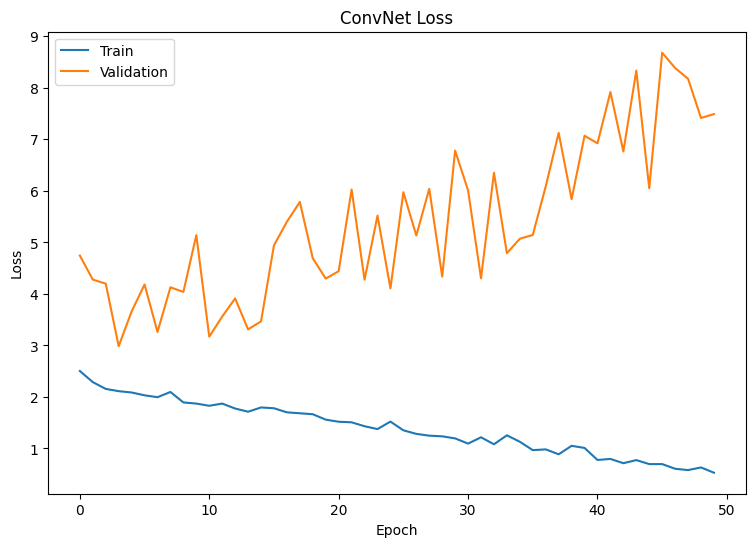

In [66]:
train_loss = deepcopy(convnet_stats[0])
valid_loss = deepcopy(convnet_stats[2])

plot_values(train_loss, valid_loss, 'Loss', 'ConvNet Loss')

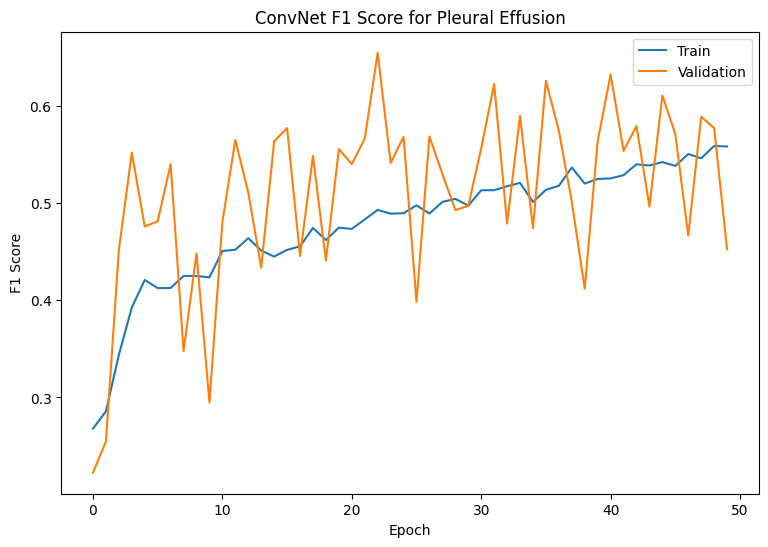

In [67]:
train_f1_pEff = process_tensors(convnet_stats[1])
valid_f1_pEff = process_tensors(convnet_stats[3])

plot_values(train_f1_pEff, valid_f1_pEff, 'F1 Score', 'ConvNet F1 Score for Pleural Effusion')

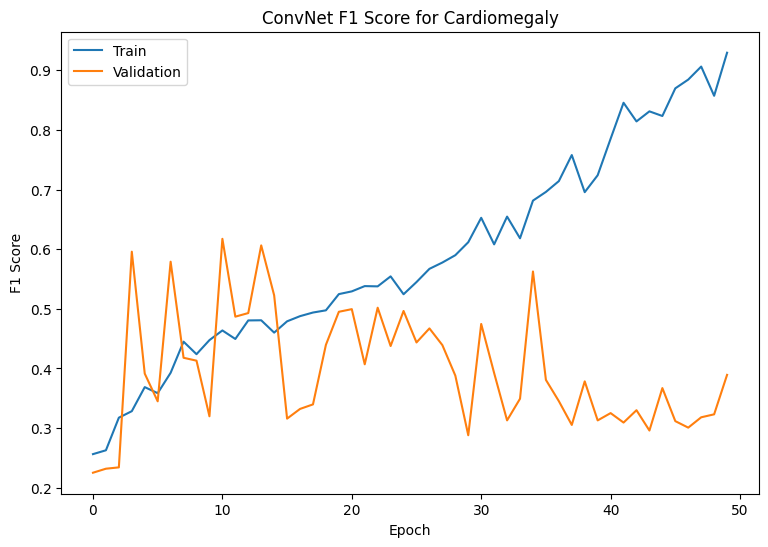

In [68]:
train_f1_cardio = process_tensors(convnet_stats[5])
valid_f1_cardio = process_tensors(convnet_stats[7])

plot_values(train_f1_cardio, valid_f1_cardio, 'F1 Score', 'ConvNet F1 Score for Cardiomegaly')

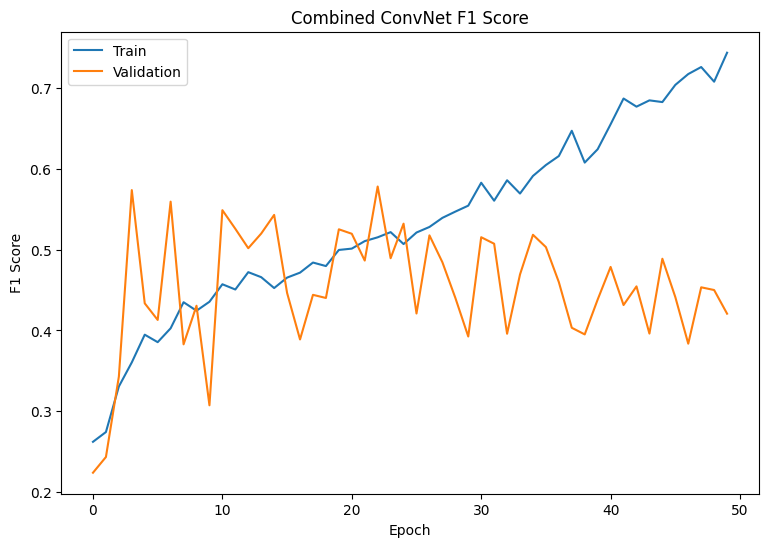

In [69]:
train_f1 = np.mean([train_f1_pEff, train_f1_cardio], axis=0)
val_f1 = np.mean([valid_f1_pEff, valid_f1_cardio], axis=0)

plot_values(train_f1, val_f1, 'F1 Score', 'Combined ConvNet F1 Score')

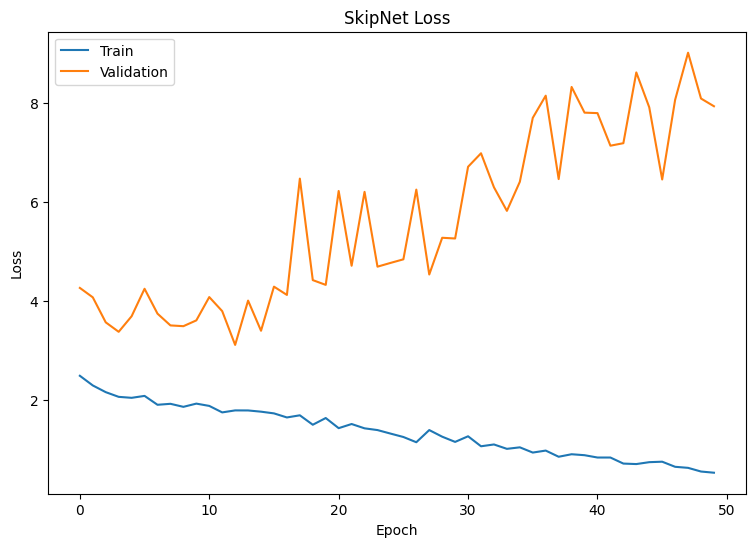

In [70]:
train_loss = deepcopy(skipnet_stats[0])
valid_loss = deepcopy(skipnet_stats[2])

plot_values(train_loss, valid_loss, 'Loss', 'SkipNet Loss')

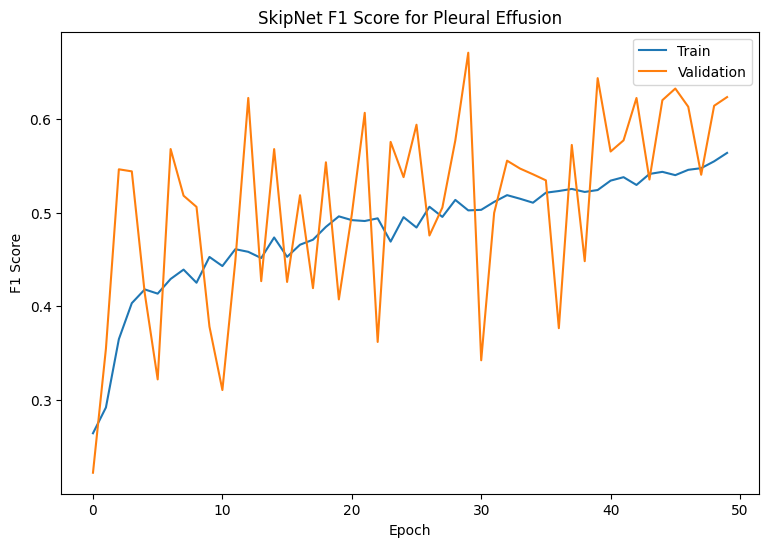

In [71]:
train_f1_pEff = process_tensors(skipnet_stats[1])
valid_f1_pEff = process_tensors(skipnet_stats[3])

plot_values(train_f1_pEff, valid_f1_pEff, 'F1 Score', 'SkipNet F1 Score for Pleural Effusion')

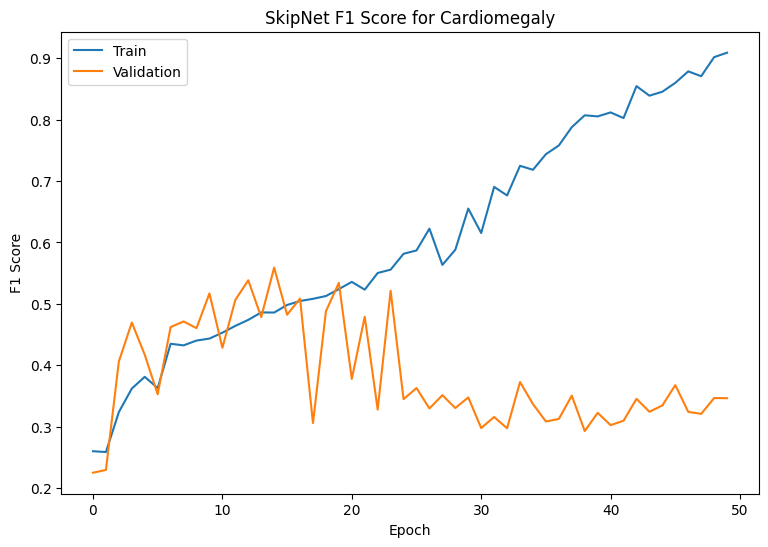

In [72]:
train_f1_cardio = process_tensors(skipnet_stats[5])
valid_f1_cardio = process_tensors(skipnet_stats[7])

plot_values(train_f1_cardio, valid_f1_cardio, 'F1 Score', 'SkipNet F1 Score for Cardiomegaly')

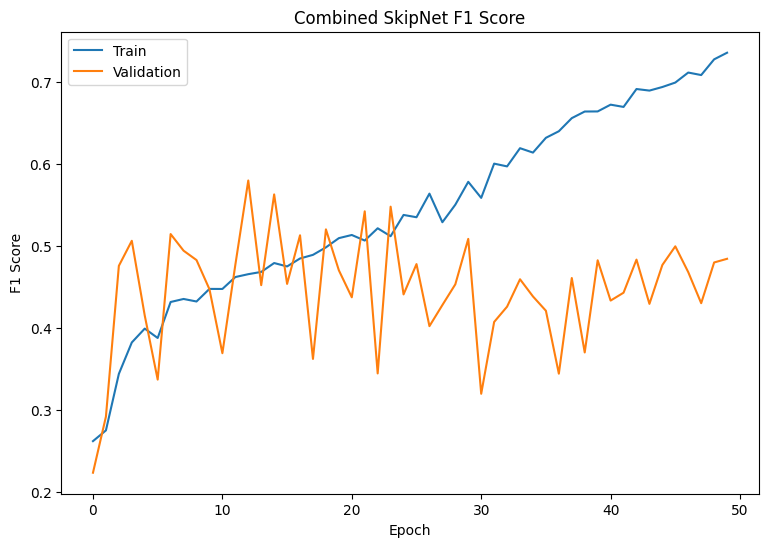

In [73]:
train_f1 = np.mean([train_f1_pEff, train_f1_cardio], axis=0)
val_f1 = np.mean([valid_f1_pEff, valid_f1_cardio], axis=0)

plot_values(train_f1, val_f1, 'F1 Score', 'Combined SkipNet F1 Score')

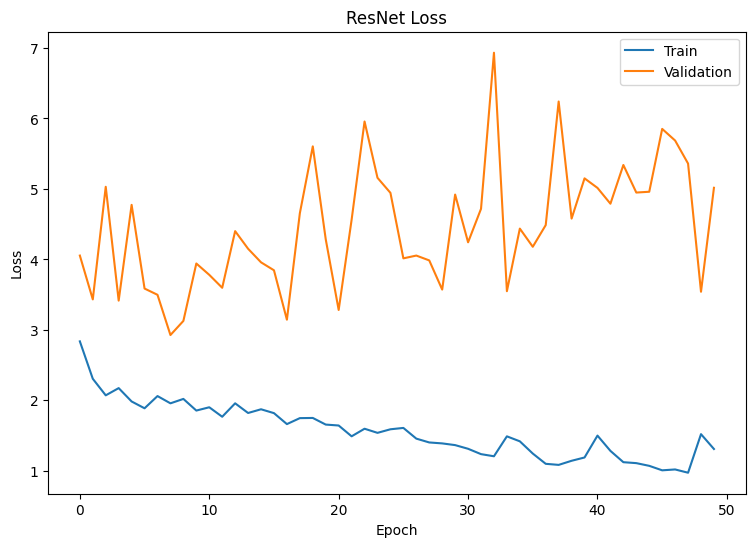

In [74]:
train_loss = deepcopy(resnet_stats[0])
valid_loss = deepcopy(resnet_stats[2])

plot_values(train_loss, valid_loss, 'Loss', 'ResNet Loss')

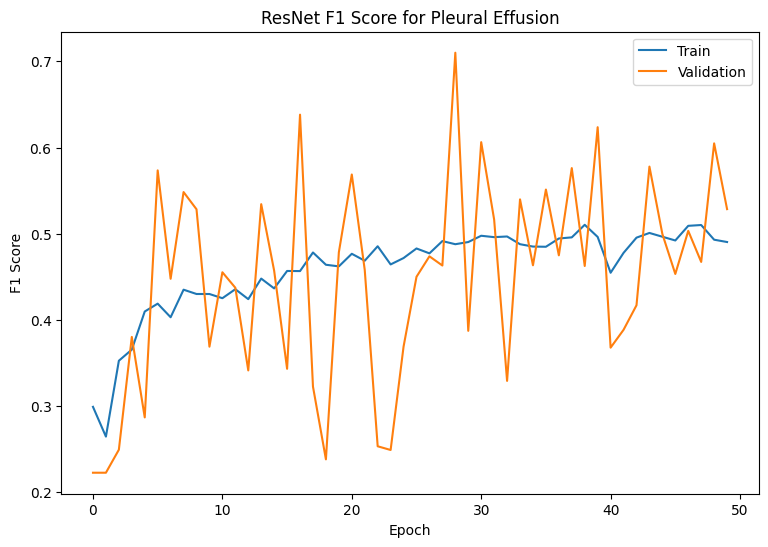

In [75]:
train_f1_pEff = process_tensors(resnet_stats[1])
valid_f1_pEff = process_tensors(resnet_stats[3])

plot_values(train_f1_pEff, valid_f1_pEff, 'F1 Score', 'ResNet F1 Score for Pleural Effusion')

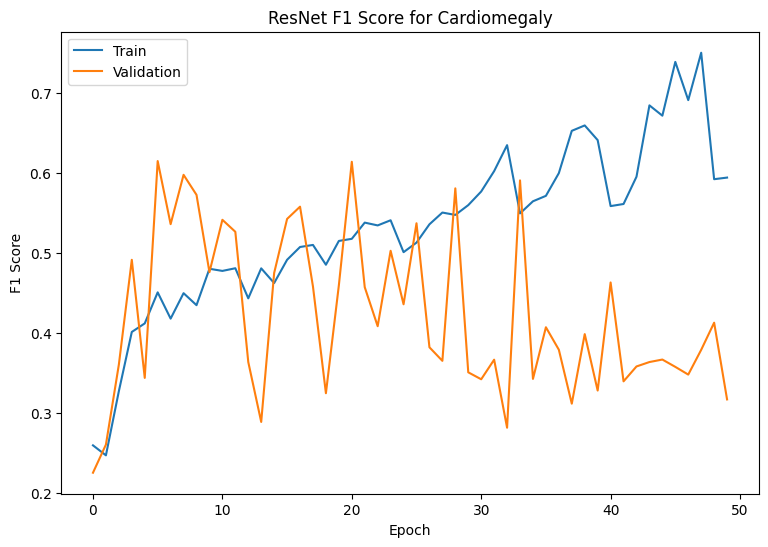

In [76]:
train_f1_cardio = process_tensors(resnet_stats[5])
valid_f1_cardio = process_tensors(resnet_stats[7])

plot_values(train_f1_cardio, valid_f1_cardio, 'F1 Score', 'ResNet F1 Score for Cardiomegaly')

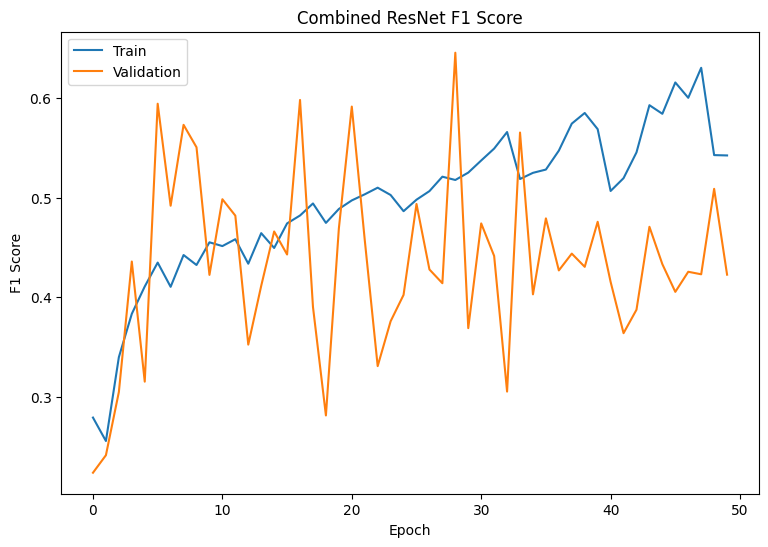

In [77]:
train_f1 = np.mean([train_f1_pEff, train_f1_cardio], axis=0)
val_f1 = np.mean([valid_f1_pEff, valid_f1_cardio], axis=0)

plot_values(train_f1, val_f1, 'F1 Score', 'Combined ResNet F1 Score')